<a href="https://colab.research.google.com/github/brandjtc/Emergency-Review-Scraper-and-Analysis/blob/main/semanticSimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from scipy.spatial.distance import cosine
import pandas as pd
import io
from google.colab import files

def get_embedding(model, tokenizer, texts):
    # Tokenize input texts and get corresponding token ids
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

    # Get the embeddings for the input texts
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()

def calculate_similarity(model, tokenizer, dimensions, sentences):
    # Get embeddings for both dimensions and sentences
    embeddings_dimensions = get_embedding(model, tokenizer, dimensions)
    embeddings_sentences = get_embedding(model, tokenizer, sentences)

    # Calculate cosine similarity
    return 1 - cosine(embeddings_dimensions, embeddings_sentences)

# Load pre-trained BERT model and tokenizer
#check what kind of pre-processing the model does: tokenization? removes stopwords?
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
!pip install sentence_transformers
!pip install requests
import requests
import json
from sentence_transformers import SentenceTransformer, util
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 3.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from google.colab import files
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Dictionary with keys being construct names and values being the definitions
dimensions_dict = {"Activation": "the affordance to put the user in a state of alert within a useful timeframe upon receiving an emergency notification",
                   "Saliency": "the affordance to put the user in a state of alert that is congruent with the type of emergency and its severity",
                   "Autonomy": "the affordance minimize the user’s intervention when configuring the apps by means of effective default settings upon installation",
                   "Usability": "the affordance to enable the user to interact with the app easily",
                   "Deep Trust": "the affordance to increase the user’s level of confidence that the application is designed to support only its intended use",
                   "Currency": "the affordance to increase the user’s level of confidence that the application is designed to support only its intended use.",
                   "Completeness": "the affordance to provide a user with a comprehensive representation of the emergency and the counteractions to take",
                   "Exactitude": "the affordance to provide a user with a correct and precise representation of an emergency and adequate counteractions to cope with it",
                   "Consistency": "the affordance to provide users with coherent and unequivocal representations of an emergency and the counteractions to take",
                   "Relevance": "the affordance to provide users with representations of an emergency that is non-trivial or poses an immediate threat",
                   "Representational Trust": "the affordance to increase the user’s level of confidence that representations of an emergency are accurate and that suggested counteractions will be effective",
                   "Promptness": "the affordance to enable the user to quickly take protective actions.",
                   "Actionability": "is the affordance to provide the user with recommendations for actions they can enact in their environment",
                   "Situational Trust": "the affordance to increase the user’s level of confidence in their ability to carry out projected actions effectively by leveraging information in the emergency notification"
                  }

def compute_similarity_matrix(file_name, min_length, max_length, cell_limit, text_list):
    # Loading the BERT model from sentence_transformers
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Extract dimensions list
    dimensions_list = list(dimensions_dict.values())

    # Filter the sentences with a set min-max text length and a limit to how many sentences
    filtered_sentences = []
    count = 0
    for sentence in text_list:
        if min_length <= len(sentence) <= max_length:
            filtered_sentences.append(sentence)
            count += 1
        if count == cell_limit:
            break

    # Computing embeddings for filtered sentences and dimensions
    embeddings_sentences = model.encode(filtered_sentences, convert_to_tensor=True)
    embeddings_dimensions = model.encode(dimensions_list, convert_to_tensor=True)

    # Calculating cosine similarity matrix
    cosine_similarity_matrix = util.pytorch_cos_sim(embeddings_sentences, embeddings_dimensions).numpy()

    # Creating a DataFrame from the cosine similarity matrix
    similarity_df = pd.DataFrame(cosine_similarity_matrix, columns=dimensions_list, index=filtered_sentences)

    # Exporting the DataFrame to an Excel file
    output_excel_path = '/content/' + file_name + '_' + str(max_length) + '.xlsx'
    similarity_df.to_excel(output_excel_path)

    # Download the Excel file
    files.download(output_excel_path)

In [ ]:
# Load the reviews dataset into a pandas DataFrame
# Must upload EmergencyReviewDB.Filtered Reviews.csv file first
df = pd.read_csv('EmergencyReviewDB.Filtered Reviews.csv')
sentences_list_reviews = df['text'].tolist()
output_name_reviews = 'reviews_similarity_matrix_all'
compute_similarity_matrix(output_name_reviews, 100, 200, 641703, sentences_list_reviews)

FileNotFoundError: [Errno 2] No such file or directory: 'EmergencyReviewDB.Filtered Reviews.csv'

In [ ]:
# Load the netflix dataset into a pandas DataFrame
# Must upload netflix_titles.csv file first
df = pd.read_csv('netflix_titles.csv')
sentences_list_netflix = df['description'].tolist()
output_name_netflix = 'netflix_similarity_matrix'
compute_similarity_matrix(output_name_netflix, 100, 200, 8500, sentences_list_netflix)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving netflix_similarity_matrix_8500.xlsx to netflix_similarity_matrix_8500.xlsx
Saving reviews_similarity_matrix_8500.xlsx to reviews_similarity_matrix_8500.xlsx
User uploaded file "netflix_similarity_matrix_8500.xlsx" with length 2313616 bytes
User uploaded file "reviews_similarity_matrix_8500.xlsx" with length 2356876 bytes


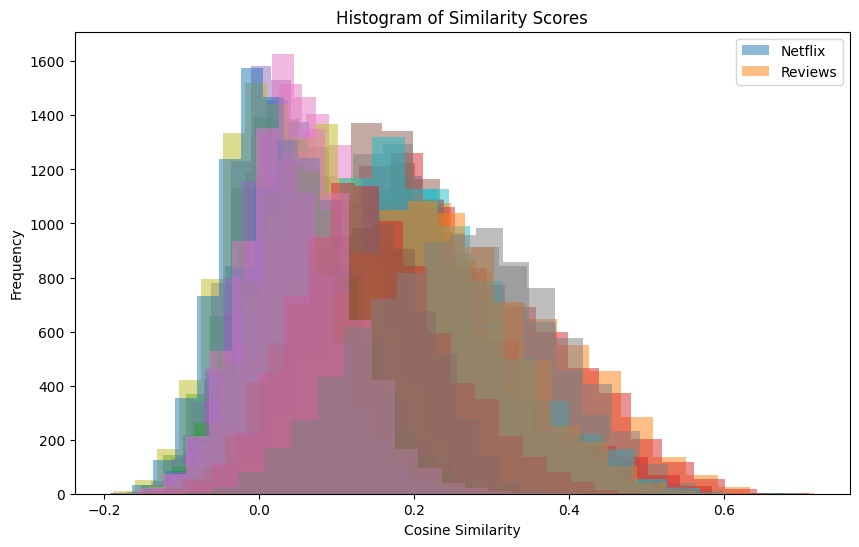

In [ ]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

uploaded = files.upload()

for filename in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=filename, length=len(uploaded[filename])))

# Load the first similarity matrix from the first Excel file (Netflix)
df1 = pd.read_excel('netflix_similarity_matrix_8500.xlsx', index_col=0)

# Load the second similarity matrix from the second Excel file (Reviews)
df2 = pd.read_excel('reviews_similarity_matrix_8500.xlsx', index_col=0)

# Plot histograms for each similarity matrix
plt.figure(figsize=(10, 6))
for col in df1.columns:
    plt.hist(df1[col], bins=20, alpha=0.5, label='Netflix: ' + col)
    plt.hist(df2[col], bins=20, alpha=0.5, label='Reviews: ' + col)

plt.title('Histogram of Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(['Netflix', 'Reviews'])
plt.show()


In [ ]:
df1.shape, df2.shape

((8500, 14), (8500, 14))

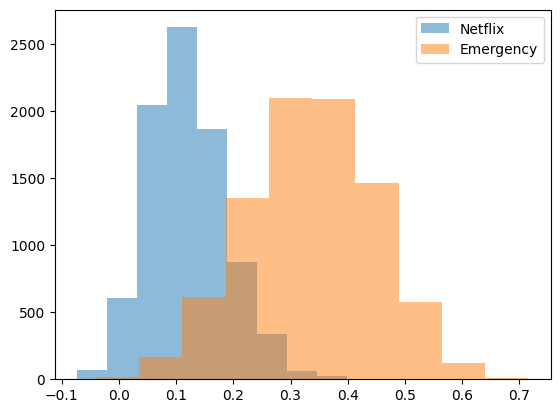

In [ ]:
plt.hist(df1.max(axis=1).values, alpha=0.5, label='Netflix')
plt.hist(df2.max(axis=1).values, alpha=0.5, label='Emergency')
plt.legend()

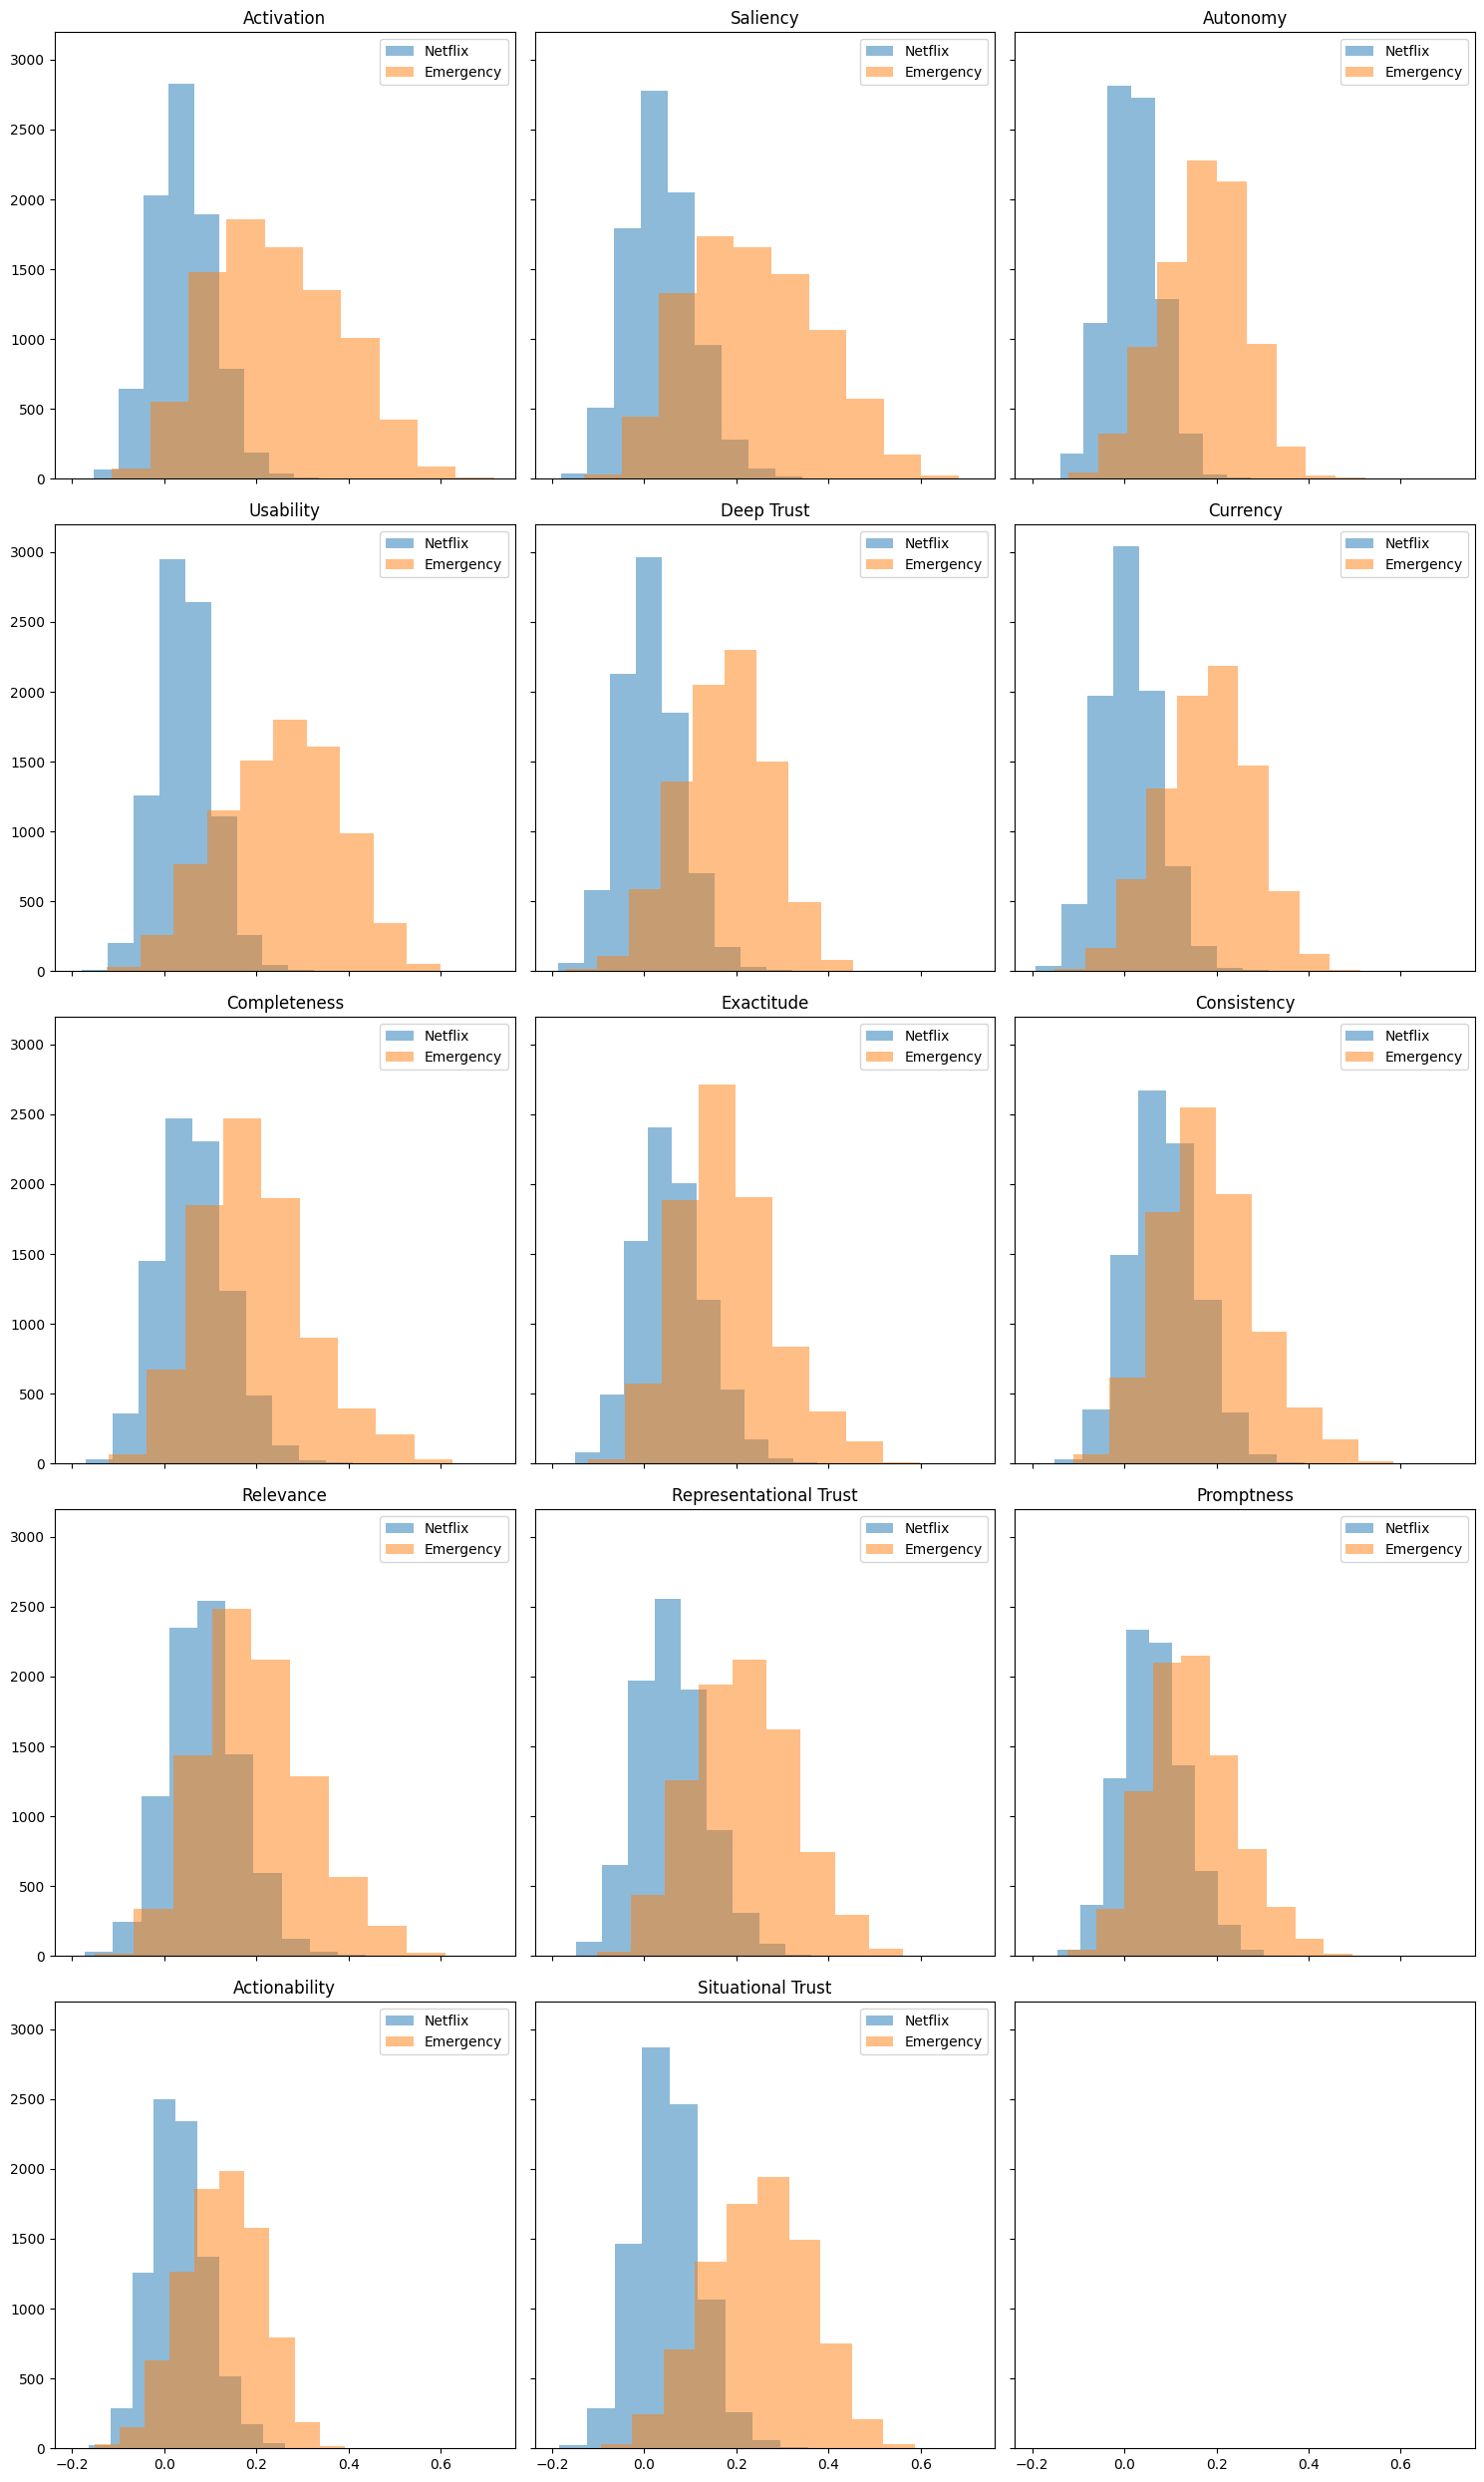

In [ ]:
netflix = df1.values
emergency = df2.values
constructs = df1.columns

dimensions_dict = {"Activation": "the affordance to put the user in a state of alert within a useful timeframe upon receiving an emergency notification",
                   "Saliency": "the affordance to put the user in a state of alert that is congruent with the type of emergency and its severity",
                   "Autonomy": "the affordance minimize the user’s intervention when configuring the apps by means of effective default settings upon installation",
                   "Usability": "the affordance to enable the user to interact with the app easily",
                   "Deep Trust": "the affordance to increase the user’s level of confidence that the application is designed to support only its intended use",
                   "Currency": "the affordance to increase the user’s level of confidence that the application is designed to support only its intended use.",
                   "Completeness": "the affordance to provide a user with a comprehensive representation of the emergency and the counteractions to take",
                   "Exactitude": "the affordance to provide a user with a correct and precise representation of an emergency and adequate counteractions to cope with it",
                   "Consistency": "the affordance to provide users with coherent and unequivocal representations of an emergency and the counteractions to take",
                   "Relevance": "the affordance to provide users with representations of an emergency that is non-trivial or poses an immediate threat",
                   "Representational Trust": "the affordance to increase the user’s level of confidence that representations of an emergency are accurate and that suggested counteractions will be effective",
                   "Promptness": "the affordance to enable the user to quickly take protective actions.",
                   "Actionability": "is the affordance to provide the user with recommendations for actions they can enact in their environment",
                   "Situational Trust": "the affordance to increase the user’s level of confidence in their ability to carry out projected actions effectively by leveraging information in the emergency notification"
                  }

# Calculate number of rows and columns for grid display
num_dimensions = df1.shape[1]
num_cols = 3  # Number of columns in the grid
num_rows = int(np.ceil(num_dimensions / num_cols))  # Number of rows in the grid

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows), sharex = True, sharey = True)

# Plot histograms for each dimension
for i in range(num_dimensions):
    row_idx = i // num_cols
    col_idx = i % num_cols

    axs[row_idx, col_idx].hist(netflix[:, i], alpha=0.5, label='Netflix')
    axs[row_idx, col_idx].hist(emergency[:, i], alpha=0.5, label='Emergency')
    dimensions_title = list(dimensions_dict.keys())
    axs[row_idx, col_idx].set_title(dimensions_title[i])
    axs[row_idx, col_idx].legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import random
from google.colab import files

df_reviews = pd.read_excel('reviews_similarity_matrix_8500.xlsx', index_col=0)

# Universal cutoff value
cutoff_value = 0.2

# Clean the DataFrame by removing non-numeric values and converting to numeric
df_reviews = df_reviews.apply(pd.to_numeric, errors='coerce').dropna()

# Assign dimension names
dimension_titles = [
    "Activation", "Saliency", "Autonomy", "Usability", "Deep Trust", "Currency", "Completeness", "Exactitude",
    "Consistency", "Relevance", "Representational Trust", "Promptness", "Actionability", "Situational Trust"
]

# Initialize a list to store all selected reviews across dimensions
all_selected_reviews = []

# Collect reviews that are below the cutoff point for each dimension
for dimension in df_reviews.columns:
    dimension_reviews = df_reviews[df_reviews[dimension] < cutoff_value].index.tolist()
    all_selected_reviews.extend(dimension_reviews)

# Randomly select a total of 10 unique reviews, if there are at least 10 to choose from
num_reviews_to_select = min(len(set(all_selected_reviews)), 10)
selected_reviews = random.sample(list(set(all_selected_reviews)), num_reviews_to_select)

# Create a new DataFrame to store the selected reviews
df_selected_reviews = pd.DataFrame({
    'Review_IDs': selected_reviews
})

# Optionally, you might want to add a column to indicate which dimension(s) each review was selected for
# This step is more complex because a review might satisfy conditions for multiple dimensions

# Specify your desired Excel file name
output_filename = 'selected_reviews.xlsx'

# Export to Excel
with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
    df_selected_reviews.to_excel(writer, index=False)

# Download the file directly, if you're in Google Colab
files.download(output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Reviews greater than .3
import pandas as pd
import random

df_reviews = pd.read_excel('reviews_similarity_matrix_8500.xlsx', index_col=0)

# Universal cutoff value
cutoff_value = 0.3

# Clean the DataFrame by removing non-numeric values and converting to numeric
df_reviews = df_reviews.apply(pd.to_numeric, errors='coerce').dropna()

# Get the number of dimensions (columns)
num_dimensions = len(df_reviews.columns)

# Assign dimension names
dimension_titles = [
    "Activation","Saliency","Autonomy","Usability","Deep Trust","Currency","Completeness","Exactitude",
    "Consistency","Relevance","Representational Trust","Promptness","Actionability","Situational Trust"
]

# Initialize a dictionary to store selected reviews for each dimension
selected_reviews_by_dimension = {dimension: [] for dimension in dimension_titles}

# Collect 20 reviews that are above the cutoff point for each dimension
for idx, dimension in enumerate(df_reviews.columns):
    dimension_reviews = df_reviews[df_reviews[dimension] < cutoff_value].index.tolist()
    num_reviews_to_select = min(len(dimension_reviews), 20)
    selected_reviews = random.sample(dimension_reviews, num_reviews_to_select)
    selected_reviews_by_dimension[dimension_titles[idx]] = selected_reviews

# Print out reviews under each dimension
for dimension, reviews in selected_reviews_by_dimension.items():
    print(f"Dimension: {dimension}")
    for review in reviews:
        print(review)
        print("-" * 50)

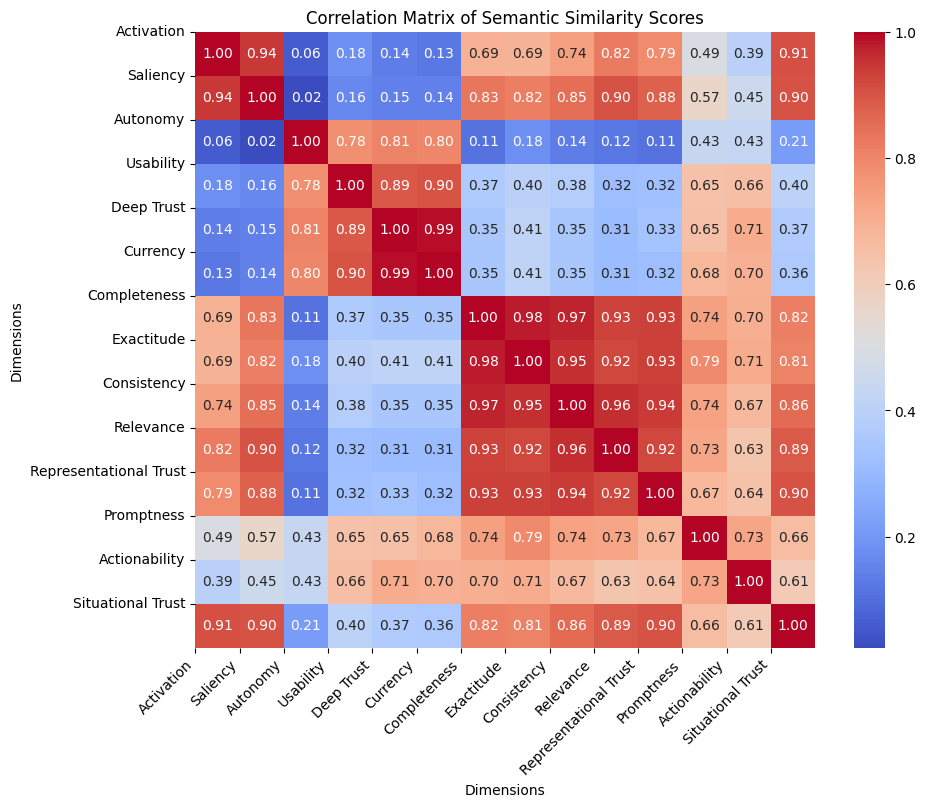

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_reviews = pd.read_excel('reviews_similarity_matrix_8500.xlsx', index_col=0)
df_reviews = df_reviews.apply(pd.to_numeric, errors='coerce').dropna()

dimension_titles = [
    "Activation","Saliency","Autonomy","Usability","Deep Trust","Currency","Completeness","Exactitude",
    "Consistency","Relevance","Representational Trust","Promptness","Actionability","Situational Trust"
]

# Compute the correlation matrix
correlation_matrix = df_reviews.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Semantic Similarity Scores')
plt.xlabel('Dimensions')
plt.ylabel('Dimensions')
plt.xticks(ticks=range(len(dimension_titles)), labels=dimension_titles, rotation=45, ha='right')
plt.yticks(ticks=range(len(dimension_titles)), labels=dimension_titles)
plt.show()